# General Configuration

#### Import dependencies and initialise random generator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, laplace
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing, svm, tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import time

# Task 2: Credit Approval

In this notebook, we are tasked with testing various methods of predicting credit approval using historic approval data in australian.csv.

We walk through the necessary steps including reading in the data and performing various pre-processing steps. We then contruct, optimise and test several models invluding SVM, MLP, decision trees and random forest.

### Read and summarise the credit approval dataset

We first read the australian.csv dataset into a Pandas DataFrame which provides an excellent framework from which we can proceed with further manipulations.

From the source, we know what the dataset should have the following structure which we can cross-reference with the version we read in as a quick sanity check:

- `x0` Categorical
- `x1` Continuous
- `x2` Continuous
- `x3` Categorical
- `x4` Categorical
- `x5` Categorical
- `x6` Continuous
- `x7` Categorical
- `x8` Categorical
- `x9` Continuous
- `x10` Categorical
- `x11` Categorical
- `x12` Continuous
- `x13` Continuous
- `y` Class Attribute

In [5]:
# read the asutralian.csv file to a dataframe
australian = pd.read_csv("australian.csv")
# verify that this variable is of pandas dataframe data type
print(type(australian))

australian.describe()

<class 'pandas.core.frame.DataFrame'>


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


Upon initial investigation of the summary table above, we can see that features $x12$ and $x13$ have max values significantly larger than their respective means which could suggest that these features contain outliers. We will perform a concrete check for outliers in a later section.

We then quickly check that there are no null values in the dataset which, from the below summary, shows that we indeed do not have any.

In [3]:
australian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      690 non-null    int64  
 1   x1      690 non-null    float64
 2   x2      690 non-null    float64
 3   x3      690 non-null    int64  
 4   x4      690 non-null    int64  
 5   x5      690 non-null    int64  
 6   x6      690 non-null    float64
 7   x7      690 non-null    int64  
 8   x8      690 non-null    int64  
 9   x9      690 non-null    int64  
 10  x10     690 non-null    int64  
 11  x11     690 non-null    int64  
 12  x12     690 non-null    int64  
 13  x13     690 non-null    int64  
 14  y       690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


The next thing is to try and understand, visually, what sort of relationships are present in the features. We do this by plotting the relationships between each of the variables below where $blue$ represents classifications of 0 and $orange$ represents classifications of 1.

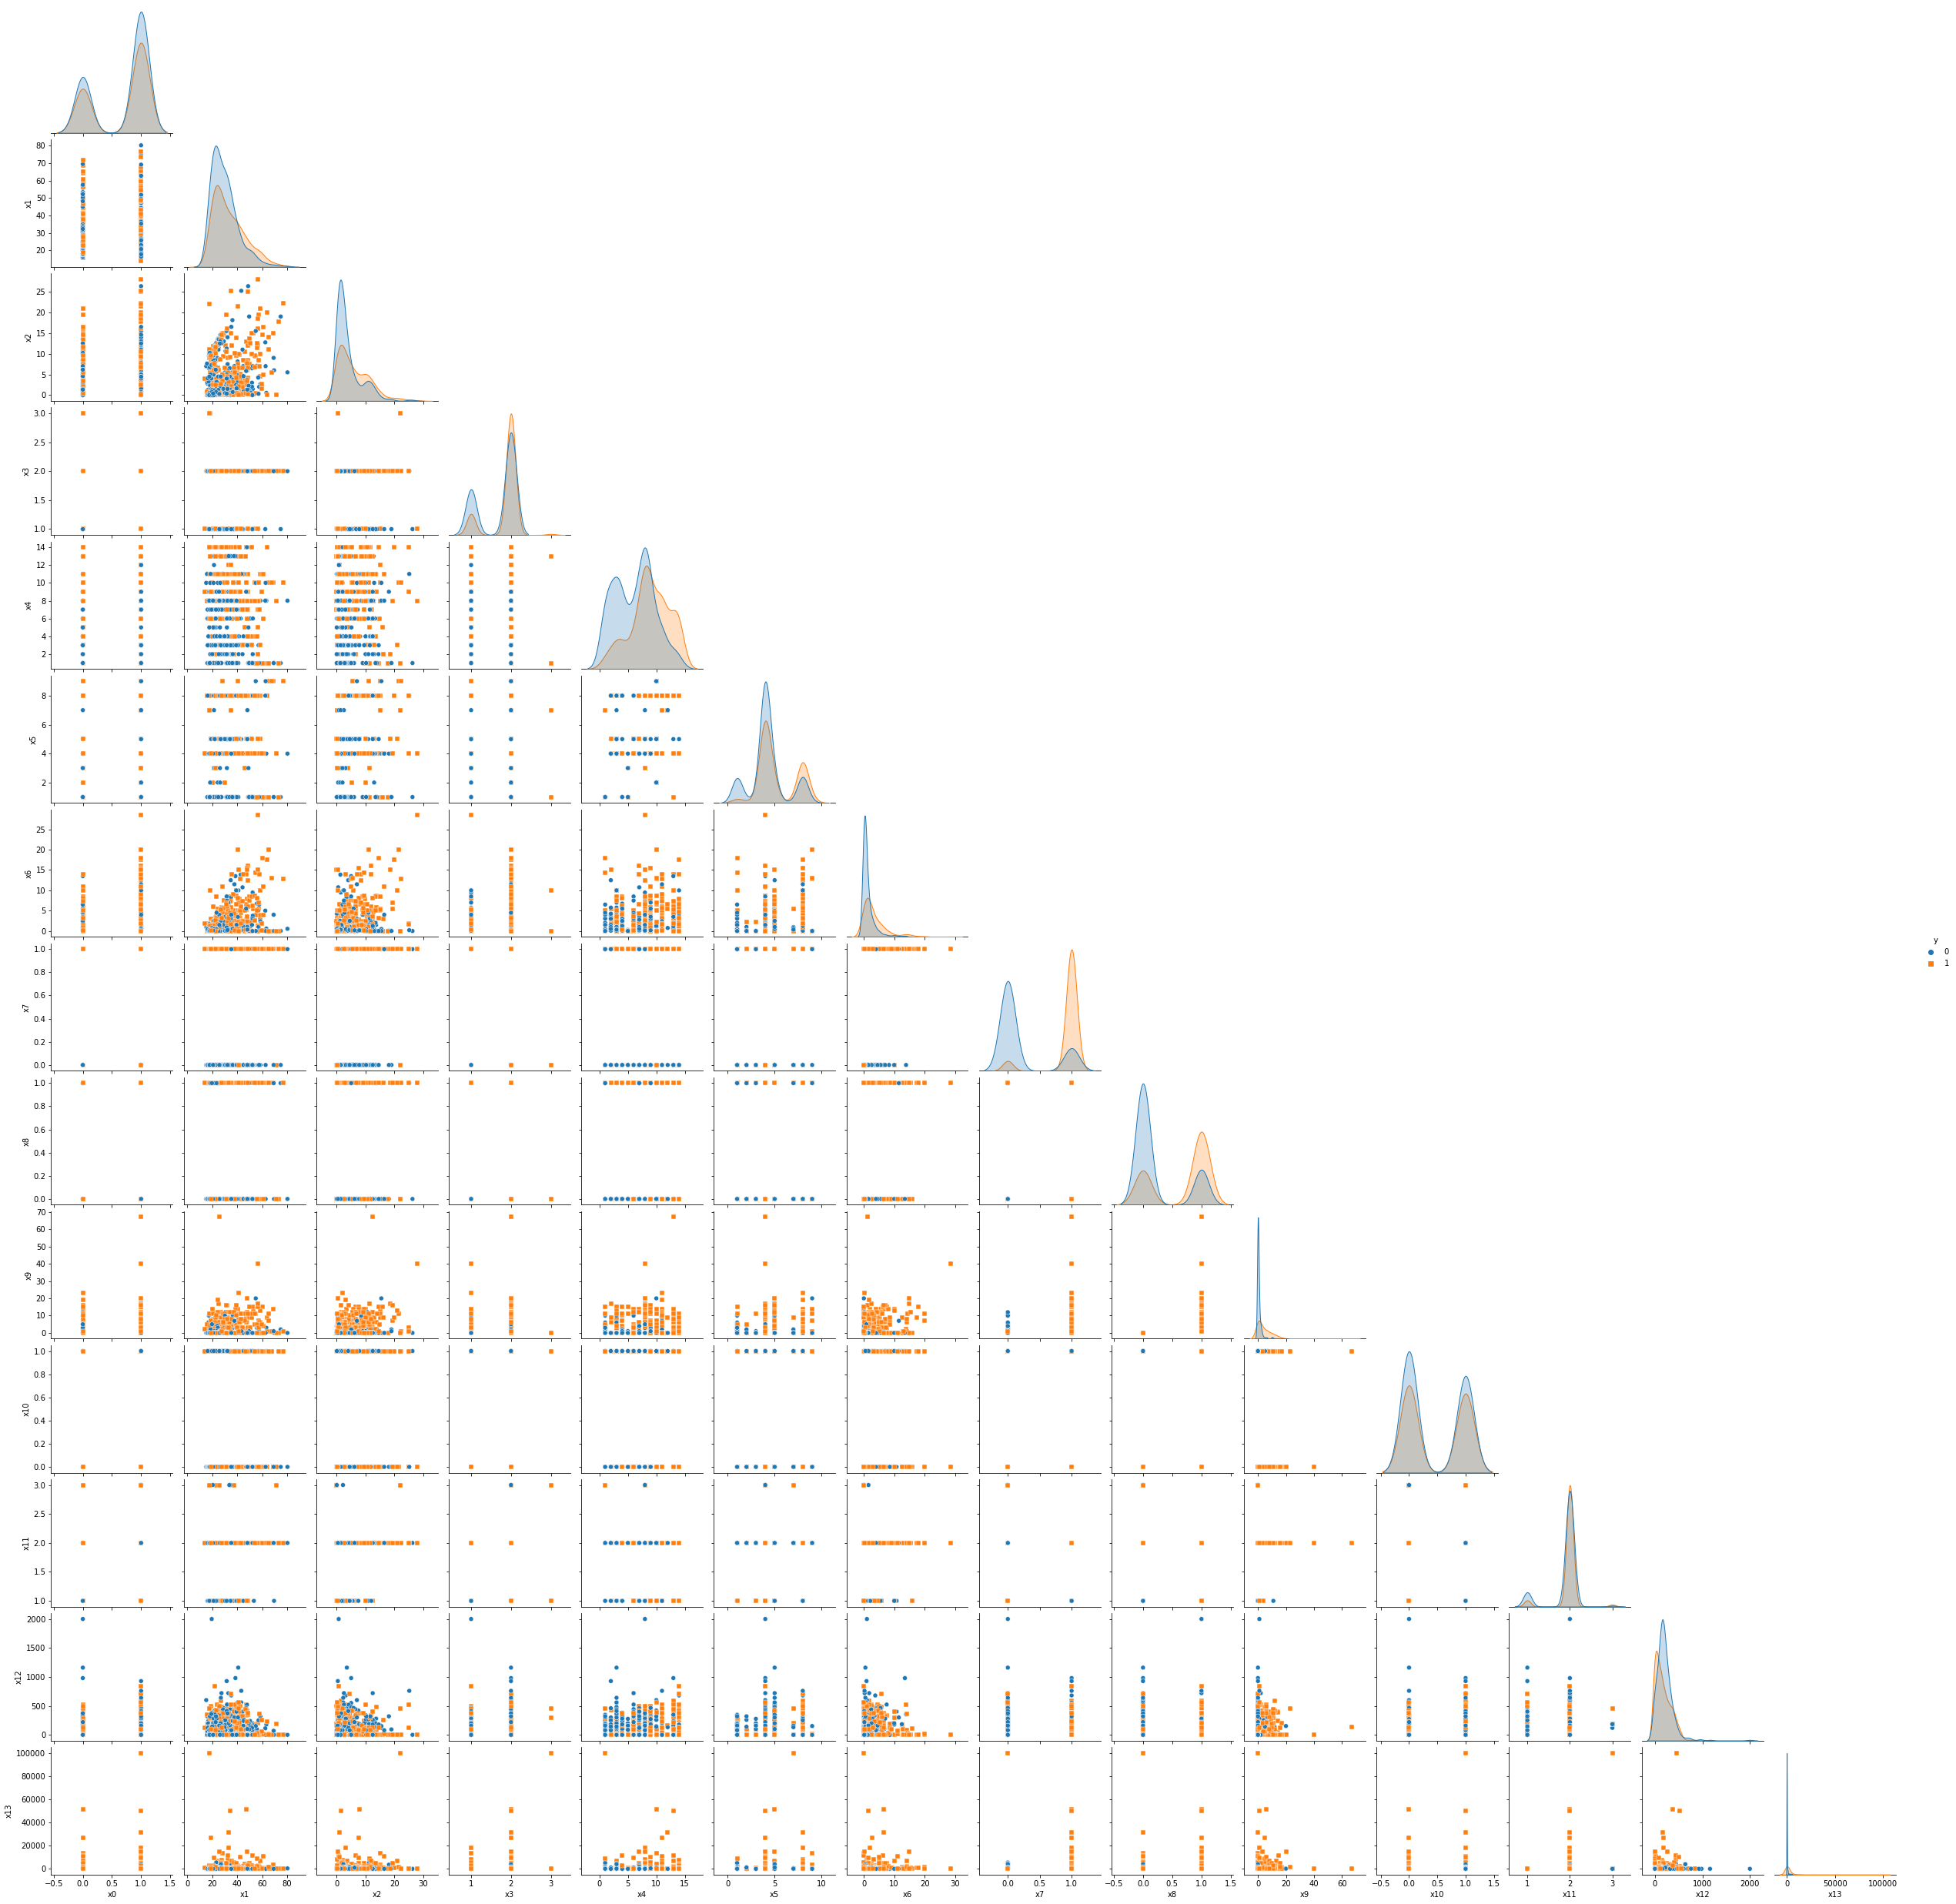

In [4]:
sns.pairplot(australian, hue='y', corner=True, markers=["o", "s"])
plt.show()

From the above plots, we can see that there exist strong relationships between:
- $x1$ and $x7$
- $x2$ and $x7$
- $x6$ and $x7$

The fact that $x7$ is a common feature in all three cases is intersting and we will investigate this further when we analyse feature importance in a more rigorous way. It is likely that $x7$ has high importance in this dataset.

### Data processing


#### Outliers

The next pre-processing step we perform is outlier removal, specifically investigating $x12$ and $x13$ as mentioned earlier. We begin the process by plotting the distributions of these two features.

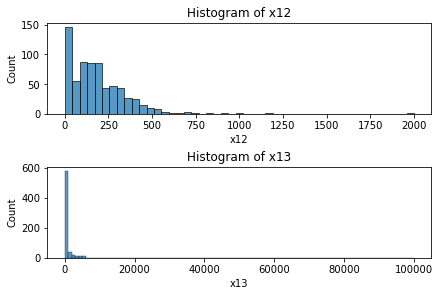

In [9]:
plt.subplots(constrained_layout=True)
plt.subplot(211)
sns.histplot(australian['x12'])
plt.title("Histogram of x12")

plt.subplot(212)
sns.histplot(australian['x13'], bins=100)
plt.title("Histogram of x13")

plt.show()

Looking at the distributions of $x12$ and $x13$, we observe in both cases "stranded" values on the far right of the distributions. This is a strong indiciation that these values are indeed outliers being isolated so far away from the rest of the distribution. From here, one must decide whether it is sensible to remove these outliers by considering the nature of these outliers in relation to our intuitive understanding of the classification problem. This, however, is beyond the scope of this project so we will end the outlier discussion here.

#### Train-test split

The next step in preparing the dataset is to seperate the australian DataFrame into *design* matrix *X* and *label* vector *y*.

We then split the dataset into train and test sub-sets using a test dataset size of 33% of the total dataset.

Finally, we perform sensible scaling since we observed earlier that some features have significantly larger scales and would therefore influence the model predictions.

In [6]:
# Define X and y matrix
y = australian['y']
X = australian.drop(['y'], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Sanity check using cross-validation with SVC classifier

Next we contruct a SVC classifier using default parameters to set a baseline mean cross-validation score which we can use to compare the later models with

- Run a cross-validation score of the SVC classifier with default parameters
- Report the mean cross-validation score

Cross-validation scores

Score 1: 0.8817204301075269
Score 2: 0.8709677419354839
Score 3: 0.8913043478260869
Score 4: 0.8152173913043478
Score 5: 0.8804347826086957

Mean cross-validation score is 0.8679289387564282


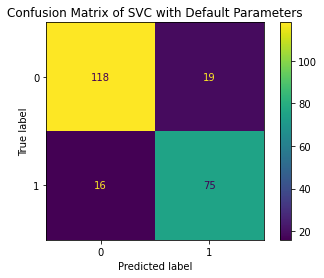

The SVC classifier score with Default on the training data is 0.9156
The SVC classifier score with Default on the test data is 0.8465


In [7]:
# Set the classifier. You need to set hyperparameters here
svc = svm.SVC()

# Train the model, aka learn from the data
svc.fit(X_train_scaled, y_train)

# Predict the value of y for any unseen example.
y_pred = svc.predict(X_test_scaled)


# print diagnostics to assess the prediction
scores = cross_val_score(svc, X_train_scaled, y_train, cv=5) 

print("Cross-validation scores\n")

for i in range(len(scores)):
    print(f"Score {i+1}: {scores[i]}")
    
print("\nMean cross-validation score is", scores.mean())

# confusion matrix with colour and labels
cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc.classes_)
disp.plot()
plt.title("Confusion Matrix of SVC with Default Parameters")
plt.show()

# Calculate the classifier scores on both the train and test datasets
score_default_train = round(svc.score(X_train_scaled, y_train), 4)
score_default_test = round(svc.score(X_test_scaled, y_test), 4)


print("The SVC classifier score with Default on the training data is", 
      score_default_train)
print("The SVC classifier score with Default on the test data is", 
      score_default_test)

### Hyperparameter optimisation

Now we perform hyperparameter optimisation for the linear and rbf kernals for the SVC classifier. We tune the regularisation parameter $C$ for the linear kernal and the scale parameter $\gamma$ for the rbf kernal, as well as $C$.

**Tuning hyperparameter *C* for the linear kernal**

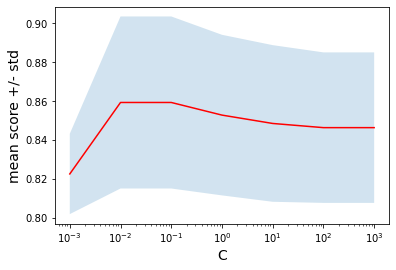

In [8]:
# set the grid 
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_mean = []
score_std = []

for C_val in C_vals:
    # set the classifier with the corresponding hyperparameter
    svc = svm.SVC(kernel='linear', C=C_val)
    # This the cross-validation. It is the important and expensive part of the code.
    scores = cross_val_score(svc, X_train_scaled, y_train)  
    # record the mean and std of the score
    score_mean.append(scores.mean())
    score_std.append(scores.std())
    
# plot the scores as function of hyperparameter
# we first convert our mean and std list to np.arrays
score_mean = np.array(score_mean)
score_std = np.array(score_std)

plt.semilogx(C_vals, score_mean,'r')
plt.fill_between(C_vals, score_mean-score_std, score_mean+score_std, alpha=0.2)
plt.xlabel("C", fontsize="14")
plt.ylabel("mean score +/- std", fontsize="14")
plt.show()

Interpreting the results, it seems that an optimal value for C is around 0.01 since this provides the highest mean score. If we were to pick a value for $C$ with lower standard deviation, such as 0.001, we would be sacrificing significant mean score performance.

**Tuning hyperparameter $c$ and $\gamma$ for the rbf kernal**

Since we have two hyperparameters to tune in the rbf kernel, we make use of Sklearn's GridSearch function to reduce the complexity of the code needed to perform this optimisation.

In [9]:
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

svc = svm.SVC()

# Set the grid
c_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
g_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Define the kernel type and parameters to be tuned
tuned_parameters = [
    {"kernel": ["rbf"], 
     "gamma": g_vals, 
     "C": c_vals}]

# Run the grid search
svc_rbf = GridSearchCV(svc, tuned_parameters, cv=5)
svc_rbf.fit(X_train_scaled, y_train)
r_score_mean = svc_rbf.cv_results_["mean_test_score"]
r_score_std = svc_rbf.cv_results_["std_test_score"]

print("rbf Hyperparameter:", svc_rbf.best_params_)
print("rbf Mean_cross_validated Score of the best_estimator:", round(svc_rbf.best_score_, 4))

rbf Hyperparameter: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
rbf Mean_cross_validated Score of the best_estimator: 0.8723


Interpreting the results, we see the optimal $C$ value is 0.1 and the optimal $\gamma$ is 0.01

#### Test and compare original classifier with new one using tuned hyperparameters

Now we compare the performance of both the linear and rbf kernels using both the default hyperparameters and the tuned versions from above.

Original linear model mean cross-validation score is 0.8527115474520806
New linear model mean cross-validation score is 0.8592099111734456
Original rbf model mean cross-validation score is 0.8679289387564282
New rbf model mean cross-validation score is 0.8722533894343151


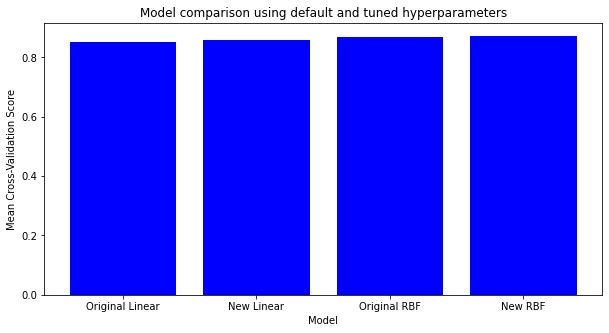

False positive rate of rbf with tuned parameters is: 0.0876


In [10]:
# Set up the four models to test
lin_1 = svm.SVC(kernel='linear')
lin_2 = svm.SVC(kernel='linear', C=0.01)                   # use optimal hyperparameter C for linear
rbf_1 = svm.SVC(kernel='rbf')
rbf_2 = svm.SVC(kernel='rbf', C=0.1, gamma=0.01)           # use optimal hyperparameters C and gamma for rbf

# Fit each of the models and generate scores over 5 runs
lin_1.fit(X_train_scaled, y_train)
y_pred = lin_1.predict(X_test_scaled)
scores_lin_1 = cross_val_score(lin_1, X_train_scaled, y_train, cv=5) 

lin_2.fit(X_train_scaled, y_train)
y_pred = lin_2.predict(X_test_scaled)
scores_lin_2 = cross_val_score(lin_2, X_train_scaled, y_train, cv=5) 

rbf_1.fit(X_train_scaled, y_train)
y_pred = rbf_1.predict(X_test_scaled)
scores_rbf_1 = cross_val_score(rbf_1, X_train_scaled, y_train, cv=5) 

rbf_2.fit(X_train_scaled, y_train)
y_pred = rbf_2.predict(X_test_scaled)
scores_rbf_2 = cross_val_score(rbf_2, X_train_scaled, y_train, cv=5) 

print("Original linear model mean cross-validation score is", scores_lin_1.mean())
print("New linear model mean cross-validation score is", scores_lin_2.mean())
print("Original rbf model mean cross-validation score is", scores_rbf_1.mean())
print("New rbf model mean cross-validation score is", scores_rbf_2.mean())

# Plot a bar chart to visualise the results
data = {'Original Linear': scores_lin_1.mean(), 'New Linear': scores_lin_2.mean(), 'Original RBF': scores_rbf_1.mean(), 'New RBF': scores_rbf_2.mean()}
labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, values, color ='blue')
plt.ylabel("Mean Cross-Validation Score")
plt.xlabel("Model")
plt.title("Model comparison using default and tuned hyperparameters")
plt.show()


# Calculate false-positive and false-negative rate of the tuned rbf model. We will discuss this later
tpr_rbf = recall_score(y_test, y_pred)
tnr_rbf = recall_score(y_test, y_pred, pos_label=0)
fpr_rbf = 1 - tnr_rbf
fnr_rbf = 1 - tpr_rbf

print(f"False positive rate of rbf with tuned parameters is: {round(fpr_rbf,4)}")

Looking at the above results, we can draw two conclusions:

1. In any case, the rbf kernal performs marginally better that the linear kernal

2. Tuning of hyperparameters in both cases did have a positive impact on overall performance, albeit marginal. In more complex scenarios, one should consider whether the performance gain is worth the significantly higher computational expense of the hyperparameter tuning process however, in our case, the expense is not too large due to the relative simplicity of our dataset

### Alternative methods

Now we introduce some additional models including MLP, decision tree and random forest to compare their respective performance.

#### Multi-layer Perceptron Classifier (MLP)

Firstly, we find out what the best hyperparameters are for our MLP classifier using the same GridSearch technique used previously for the SVM model with rbf kernel. In this case, the number of hyperparamers we are optimisiing for are numerous including several hidden layer sizes, activation functions, solvers and learning rates. From experience, however, these parameters can have large impacts on model performance but we try to only test realistic options in each case. For example, it is unlikely that hidden layers sizes of (100000,) are going to being optimal, so we constrain the paramter options as much as possible.

***Warning: this optimisation process is extremely computationally expensive and should not be run unless absolutely necessary. For this reason, the below code is commented out by default.***

In [11]:
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
'''
mlp = MLPClassifier(max_iter=10000)

parameters_mlp = {
    'hidden_layer_sizes': [(100,), (200,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['invscaling', 'adaptive']
}

clf_mlp = GridSearchCV(mlp, parameters_mlp, cv=5)
clf_mlp.fit(X_train_scaled, y_train)

print("MLP Hyperparameters:", clf_mlp.best_params_)
print("MLP Mean cross-validation score of the optimal model:", round(clf_mlp.best_score_, 4))
'''

'\nmlp = MLPClassifier(max_iter=10000)\n\nparameters_mlp = {\n    \'hidden_layer_sizes\': [(100,), (200,)],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'sgd\', \'adam\'],\n    \'learning_rate\': [\'invscaling\', \'adaptive\']\n}\n\nclf_mlp = GridSearchCV(mlp, parameters_mlp, cv=5)\nclf_mlp.fit(X_train_scaled, y_train)\n\nprint("MLP Hyperparameters:", clf_mlp.best_params_)\nprint("MLP Mean cross-validation score of the optimal model:", round(clf_mlp.best_score_, 4))\n'

To save us from running the time-intensive optimisation again, the output would have been:

> MLP Hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}

> MLP Mean cross-validation score of the optimal model: 0.8744

Having now found the optimal model parameters, we construct and test the final MLP classifier.

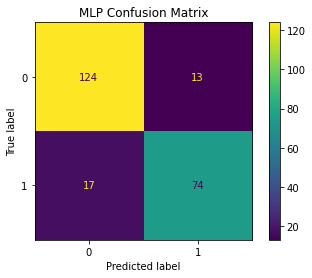

MLP training data score is: 0.9026
MLP test data score is: 0.8684
False positive rate is: 0.0949


In [12]:
# Initialise the MLP classifier with optimal parameters
mlp = MLPClassifier(max_iter=10000, hidden_layer_sizes=(100,), activation='relu', solver='sgd', learning_rate='adaptive')
mlp.fit(X_train_scaled, y_train)
mlp_y_pred = mlp.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, mlp_y_pred, labels=mlp.classes_)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)

# Generate model scores
score_train_mlp = round(mlp.score(X_train_scaled, y_train), 4)
score_test_mlp = round(mlp.score(X_test_scaled, y_test), 4)

# Plot the confusion matrix
disp_mlp.plot()
plt.title("MLP Confusion Matrix")
plt.show()

print(f"MLP training data score is: {score_train_mlp}")
print(f"MLP test data score is: {score_test_mlp}")

# Calculate false-positive and false-negative rate
tpr_mlp = recall_score(y_test, mlp_y_pred)
tnr_mlp = recall_score(y_test, mlp_y_pred, pos_label=0)
fpr_mlp = 1 - tnr_mlp
fnr_mlp = 1 - tpr_mlp

print(f"False positive rate is: {round(fpr_mlp,4)}")

#### Decision Tree

Again, we follow the same process as before in performing a GridSearch for the optimal hyperparameters for the decision tree classifier.

In [13]:
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/tree.html
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Initialise decision tree
dt = tree.DecisionTreeClassifier()

# Define parameters for tuning
parameters_dt = {'criterion':['gini','entropy'],
                 'max_depth':[2,3,4,5,6,7,8,9,10]}

# Perform grid search
clf_dt = GridSearchCV(dt, parameters_dt, cv=5)
clf_dt.fit(X_train_scaled, y_train)

print("Decision Tree Hyperparameters:", clf_dt.best_params_)
print("Decision Tree Mean cross-validation score of the optimal model:", round(clf_dt.best_score_, 4))

Decision Tree Hyperparameters: {'criterion': 'entropy', 'max_depth': 4}
Decision Tree Mean cross-validation score of the optimal model: 0.868


And now we construct and test the optimal decision tree classifier.

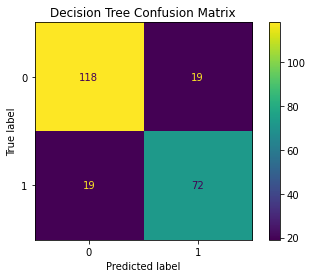


Decision tree training data score is: 0.8983
Decision tree test data score is: 0.8333
False positive rate is: 0.1387


In [14]:
# Initialise the decision tree
dt = clf_dt.best_estimator_
dt.fit(X_train_scaled, y_train)
dt_y_pred = dt.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, dt_y_pred, labels=dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)

# Generate model scores
score_train_dt = round(dt.score(X_train_scaled, y_train), 4)
score_test_dt = round(dt.score(X_test_scaled, y_test), 4)

disp_dt.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

print()
print(f"Decision tree training data score is: {score_train_dt}")
print(f"Decision tree test data score is: {score_test_dt}")

# Calculate false-positive and false-negative rate
tpr_dt = recall_score(y_test, dt_y_pred)
tnr_dt = recall_score(y_test, dt_y_pred, pos_label=0)
fpr_dt = 1 - tnr_dt
fnr_dt = 1 - tpr_dt

print(f"False positive rate is: {round(fpr_dt,4)}")

#### Random Forest

Again, we follow the same process as before in performing a GridSearch for the optimal hyperparameters for the random forest classifier.

***Warning: this optimisation process is extremely computationally expensive and should not be run unless absolutely necessary. For this reason, the below code is commented out by default.***

In [15]:
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# ref: scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
'''
rf = RandomForestClassifier()

parameters_rf = { 'n_estimators': [200, 500],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth' : [4,5,6,7,8],
                 'criterion' :['gini', 'entropy']
}

clf_rf = GridSearchCV(rf, parameters_rf, cv=5)
clf_rf.fit(X_train_scaled, y_train)

print("Random Forest Hyperparameters:", clf_rf.best_params_)
print("Random Forest Mean cross-validation score of the optimal model:", round(clf_rf.best_score_, 4))
'''

'\nrf = RandomForestClassifier()\n\nparameters_rf = { \'n_estimators\': [200, 500],\n                 \'max_features\': [\'auto\', \'sqrt\', \'log2\'],\n                 \'max_depth\' : [4,5,6,7,8],\n                 \'criterion\' :[\'gini\', \'entropy\']\n}\n\nclf_rf = GridSearchCV(rf, parameters_rf, cv=5)\nclf_rf.fit(X_train_scaled, y_train)\n\nprint("Random Forest Hyperparameters:", clf_rf.best_params_)\nprint("Random Forest Mean cross-validation score of the optimal model:", round(clf_rf.best_score_, 4))\n'

To save us from running the time-intensive optimisation again, the output would have been:

> Random Forest Hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}

> Random Forest Mean cross-validation score of the optimal model: 0.8853

And now we construct and test the optimal random forest classifier.

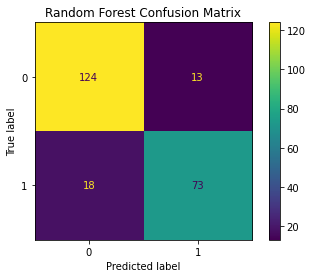


Random forest training data score is: 0.9719
Random forest test data score is: 0.864
False positive rate is: 0.0949


In [16]:
# Initialise random forest classifier
rf = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=7, criterion='gini')
rf.fit(X_train_scaled, y_train)
rf_y_pred = rf.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, rf_y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)

# Generate model scores
score_train_rf = round(rf.score(X_train_scaled, y_train), 4)
score_test_rf = round(rf.score(X_test_scaled, y_test), 4)

disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

print()
print(f"Random forest training data score is: {score_train_rf}")
print(f"Random forest test data score is: {score_test_rf}")

# Calculate false-positive and false-negative rate
tpr_rf = recall_score(y_test, rf_y_pred)
tnr_rf = recall_score(y_test, rf_y_pred, pos_label=0)
fpr_rf = 1 - tnr_rf
fnr_rf = 1 - tpr_rf

print(f"False positive rate is: {round(fpr_rf,4)}")

### Model comparison

Having now generated optimal models using MLP, Decision Tree and Random Forest, we can discuss the results.



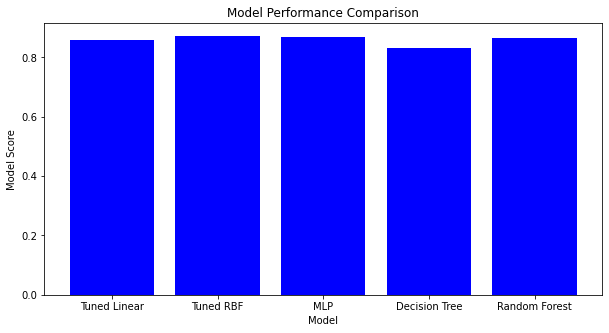

Model Scores:
Tuned Linear 0.8592
Tuned RBF 0.8723
MLP 0.8684
Decision Tree 0.8333
Random Forest 0.864


In [21]:
# Plot a bar chart to visualise the results
data = {'Tuned Linear': scores_lin_2.mean(),'Tuned RBF': scores_rbf_2.mean(), 'MLP': score_test_mlp, 'Decision Tree': score_test_dt, 'Random Forest': score_test_rf}
labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, values, color ='blue')
plt.ylabel("Model Score")
plt.xlabel("Model")
plt.title("Model Performance Comparison")
plt.show()

print("Model Scores:")
for i in range(len(data)):
    print(labels[i], round(values[i],4))

From the above results, we can see that the SVC model with rbf kernel and tuned hyperparameters performed the best with a mean score of 0.8723. It is clear, however, that it does not perform significantly better than any of the other models. On the other hand, it is a simpler and less computationally expensive model than, for example, MLP and random forest, which also acts in its favour.

Besides just model scores, we can also consider metrics such as false-positive rate which can be calculated from the respective confusion matrices.

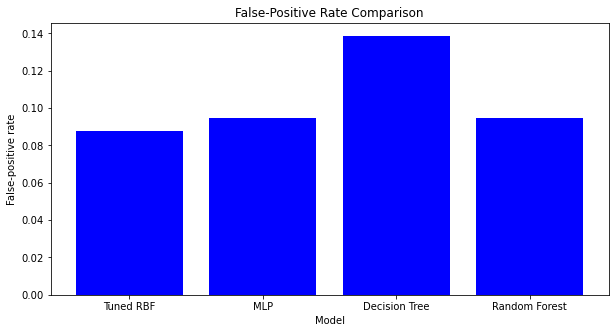

Tuned RBF 0.0876
MLP 0.0949
Decision Tree 0.1387
Random Forest 0.0949


In [18]:
data = {'Tuned RBF': fpr_rbf, 'MLP': fpr_mlp, 'Decision Tree': fpr_dt, 'Random Forest': fpr_rf}
labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, values, color ='blue')
plt.ylabel("False-positive rate")
plt.xlabel("Model")
plt.title("False-Positive Rate Comparison")
plt.show()

for i in range(len(data)):
    print(labels[i], round(values[i],4))

The false-positive rate can be calculated by number of false positives divided by the total number of negatives and can be an important metric in scenarios such as credit ratings where the cost to assigning a false positive can be significant.

Having calculated these values, we now see that the tuned rbf model has a more substantial lead over the other models.

In a scenario such as credit ratings, false-positive rate can arguably be even more important than minor improvements in model scores since there can be large costs associated with false-positive classifications leading to loans being granted to unfit individuals. On the other hand, there is a much less-significant cost associated with false-negatives in this particular case, hence why we only focus on false-positives.

In conclusion, due to the relative simplicity of the SVM with rbf kernel model, it's marginally superior overall score and significantly better false-positive rate, it stands out as the best overall model.

### Feature importance

Below we investigate feature performance more rigorously by generating a plot of importances using permutation on the random forest model.

Elapsed time to compute the importances: 2.236 seconds


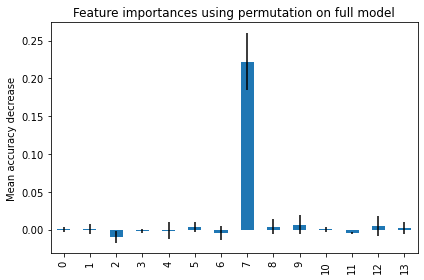

In [19]:
# ref: scikit-learn documentation: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

start_time = time.time()
result = permutation_importance(
    rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In the above plot, the blue bars are the feature importances and the error bars represent the inter-trees variability. Looking at the plot, it is clear that feature $x7$ is by far the most important with all other features seeming insignificant on a relative basis.

From here, we could remove the other features and re-perform the model fitting to assess the results but this is out of the scope of this project.

Another way we can investigate feature importance is by plotting violin plots.

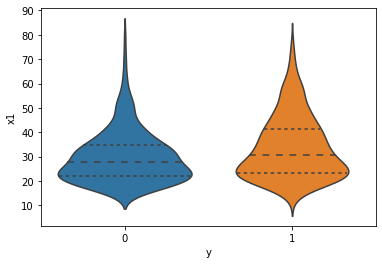

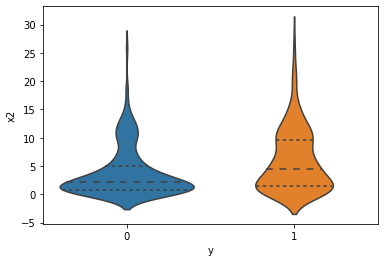

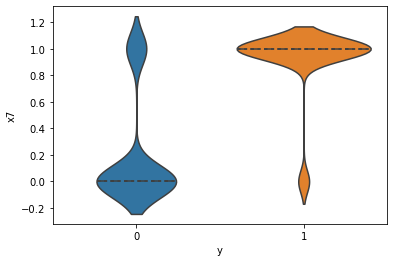

In [20]:
sns.violinplot(x='y', y='x1', data=australian, inner='quartile')
plt.show()

sns.violinplot(x='y', y='x2', data=australian, inner='quartile')
plt.show()

sns.violinplot(x='y', y='x7', data=australian, inner='quartile')
plt.show()

Above, we can see a small sample of violin plots for some of the features and they largely support our findings from the permutation method above. We clearly see that feature $x7$ displays the best "seperation" between classification 0 and 1 whereas all other features are distributed in a way that generates more "noise" thereby diminishing their ability to "describe" the classification of each case.

One potential remedy for the lack of "predictive power" in a lot of the features could be the implementation of one-hot encoding. One-hot encoding is used to represent categorical features as numerical data by converting the categorical features into a binary vector where each vector has a length equal to the number of possible values the feature can have. This can help to improve the effective distribution of these categorical features, allowing the machine learning methods to learn more effectively from the features in the data.